This file contains code that plots results from ST, WT, etc. on combined figures.

# Imports

In [1]:
import csv, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from obspy.geodetics import gps2dist_azimuth
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plots

In [2]:
# Directory
INPUT_TXT = '/Users/emmanuelzheng/Downloads/Synthetics/Seiobs/Combined_Results.txt'

# Toggles
plotStarOnly = False
plotLabels = False
plotSNROnly = False
plotSNROnly2 = True
snlg_SNR_threshold = 3.0
snlg_SNR_threshold_2 = 2.0


## Sn/Lg v. d-H

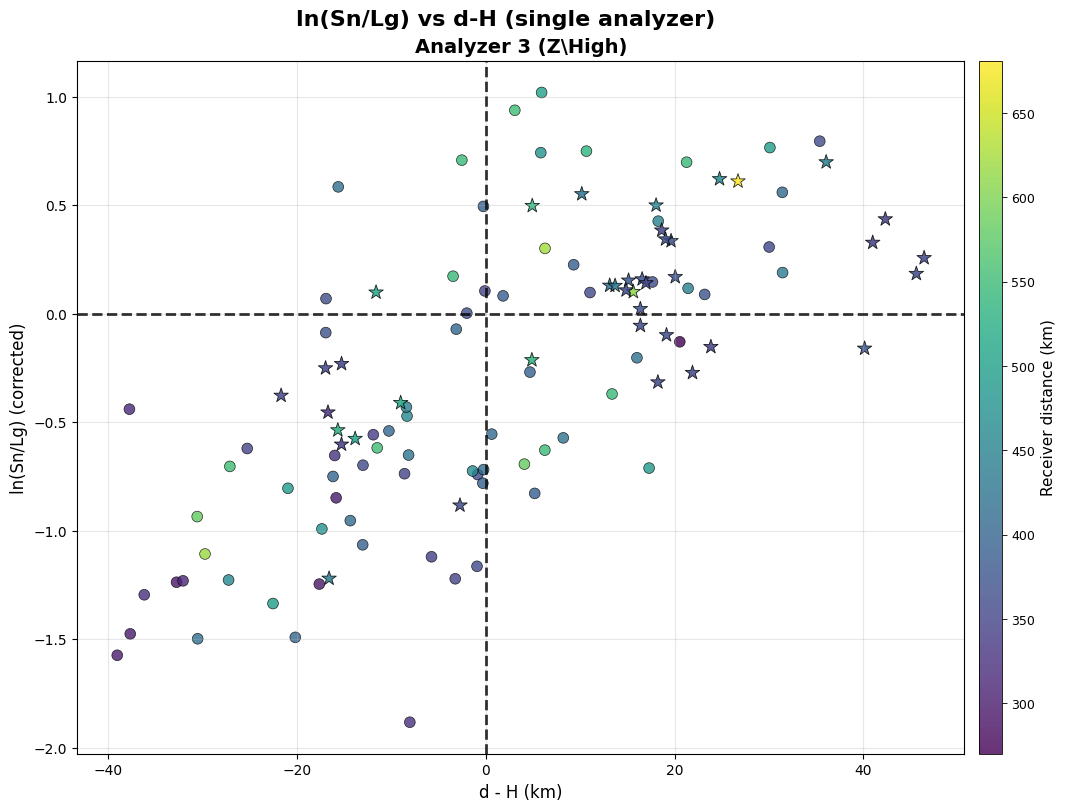

In [3]:
# Select analyzer to plot (1–4)
ANALYZER_INDEX = 3  # change to 2, 3, or 4 as needed

# Dashed guidelines per analyzer: (d_h_value, ln_snlg_value)
dashed_line_values = [
    (0, 0),  # Analyzer 1
    (0, 0),  # Analyzer 2
    (0, 0),  # Analyzer 3
    (0, 0),  # Analyzer 4
]

STATION_COORDS = {
    'LSA': (29.6573, 91.1042),
    'KBL': (34.53, 69.17),
}

rows = []
with open(INPUT_TXT, 'r') as f:
    rdr = csv.reader(f, delimiter='\t')
    for r in rdr:
        if r: rows.append(r)

# Collect values for all analyzers; we'll select one later
d_h_values = []
is_special = []

y1, y2, y3, y4 = [], [], [], []
snr1, snr2, snr3, snr4 = [], [], [], []  # used for masks only if requested

recv_dist_km_1, recv_dist_km_2, recv_dist_km_3, recv_dist_km_4 = [], [], [], []

for r in rows:
    evla = float(r[1]); evlo = float(r[2])

    d_h_values.append(float(r[6]) if r[6] != '' else np.nan)
    is_special.append(r[7] == '*')

    # Analyzer 1
    s1 = r[8]; st1 = 'LSA' if 'LSA' in s1 else 'KBL'
    dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st1][0], STATION_COORDS[st1][1])
    recv_dist_km_1.append(dist_m / 1000.0)
    y1.append(float(r[9]) if r[9] != '' else np.nan)
    snr1.append(float(r[11]) if r[11] != '' else np.nan)

    # Analyzer 2
    s2 = r[14]; st2 = 'LSA' if 'LSA' in s2 else 'KBL'
    dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st2][0], STATION_COORDS[st2][1])
    recv_dist_km_2.append(dist_m / 1000.0)
    y2.append(float(r[15]) if r[15] != '' else np.nan)
    snr2.append(float(r[17]) if r[17] != '' else np.nan)

    # Analyzer 3
    s3 = r[20]; st3 = 'LSA' if 'LSA' in s3 else 'KBL'
    dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st3][0], STATION_COORDS[st3][1])
    recv_dist_km_3.append(dist_m / 1000.0)
    y3.append(float(r[21]) if r[21] != '' else np.nan)
    snr3.append(float(r[23]) if r[23] != '' else np.nan)

    # Analyzer 4
    s4 = r[26]; st4 = 'LSA' if 'LSA' in s4 else 'KBL'
    dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st4][0], STATION_COORDS[st4][1])
    recv_dist_km_4.append(dist_m / 1000.0)
    y4.append(float(r[27]) if r[27] != '' else np.nan)
    snr4.append(float(r[29]) if r[29] != '' else np.nan)

# To numpy
d_h_values = np.array(d_h_values)
is_special = np.array(is_special, dtype=bool)

y1 = np.array(y1); y2 = np.array(y2); y3 = np.array(y3); y4 = np.array(y4)
snr1 = np.array(snr1); snr2 = np.array(snr2); snr3 = np.array(snr3); snr4 = np.array(snr4)

recv_dist_km_1 = np.array(recv_dist_km_1)
recv_dist_km_2 = np.array(recv_dist_km_2)
recv_dist_km_3 = np.array(recv_dist_km_3)
recv_dist_km_4 = np.array(recv_dist_km_4)

# Select analyzer
analyzers = {
    1: (y1, snr1, recv_dist_km_1, "Analyzer 1 (T\High)"),
    2: (y2, snr2, recv_dist_km_2, "Analyzer 2 (T\Low)"),
    3: (y3, snr3, recv_dist_km_3, "Analyzer 3 (Z\High)"),
    4: (y4, snr4, recv_dist_km_4, "Analyzer 4"),
}
y_data, snr_vals, recv_dist_km, title = analyzers[int(ANALYZER_INDEX)]
d_h_line, ln_snlg_line = dashed_line_values[int(ANALYZER_INDEX) - 1]

# Build masks
if plotSNROnly:
    snr_mask = snr_vals > snlg_SNR_threshold
elif plotSNROnly2:
    # If you have separate Sn/Lg SNRs, adapt here; otherwise use combined
    snr_mask = snr_vals > snlg_SNR_threshold_2
else:
    snr_mask = np.ones_like(y_data, dtype=bool)

valid_y = np.isfinite(y_data)
valid_x = np.isfinite(d_h_values)
valid_c = np.isfinite(recv_dist_km)
base_mask = is_special if plotStarOnly else np.ones_like(is_special, dtype=bool)

regular_base = np.zeros_like(is_special, dtype=bool) if plotStarOnly else ~is_special
special_base = is_special

# Figure and axis
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

# Color scale based on receiver distance (km)
mask_all = valid_x & valid_y & valid_c & snr_mask & base_mask
if np.any(mask_all):
    cmin = float(np.nanmin(recv_dist_km[mask_all]))
    cmax = float(np.nanmax(recv_dist_km[mask_all]))
    if not np.isfinite(cmin): cmin = 0.0
    if not np.isfinite(cmax) or cmax == cmin: cmax = cmin + 1e-6
else:
    cmin, cmax = 0.0, 1.0

scatter_for_cbar = None

# Regular points
regular_mask = regular_base & valid_x & valid_y & valid_c & snr_mask
if np.any(regular_mask):
    sc_reg = ax.scatter(
        d_h_values[regular_mask], y_data[regular_mask],
        c=recv_dist_km[regular_mask], cmap='viridis', vmin=cmin, vmax=cmax,
        marker='o', s=60, alpha=0.8, edgecolors='black', linewidth=0.5
    )
    if scatter_for_cbar is None: scatter_for_cbar = sc_reg
    if plotLabels:
        for idx in np.where(regular_mask)[0]:
            ax.annotate(f'{d_h_values[idx]:.2f}', (d_h_values[idx], y_data[idx]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

# Special points
special_mask = special_base & valid_x & valid_y & valid_c & snr_mask
if np.any(special_mask):
    sc_spec = ax.scatter(
        d_h_values[special_mask], y_data[special_mask],
        c=recv_dist_km[special_mask], cmap='viridis', vmin=cmin, vmax=cmax,
        marker='*', s=120, alpha=0.85, edgecolors='black', linewidth=0.6
    )
    if scatter_for_cbar is None: scatter_for_cbar = sc_spec
    if plotLabels:
        for idx in np.where(special_mask)[0]:
            ax.annotate(f'{d_h_values[idx]:.2f}', (d_h_values[idx], y_data[idx]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.9, weight='bold')

# Dashed guidelines
ax.axvline(x=d_h_line, color='black', linestyle='--', alpha=0.8, linewidth=2)
ax.axhline(y=ln_snlg_line, color='black', linestyle='--', alpha=0.8, linewidth=2)

# Labels and styling
ax.set_xlabel('d - H (km)', fontsize=12)
ax.set_ylabel('ln(Sn/Lg) (corrected)', fontsize=12)
ax.set_title(title, fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Slim, non-overlapping colorbar on the right for receiver distance
if scatter_for_cbar is not None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.15)
    cbar = fig.colorbar(scatter_for_cbar, cax=cax)
    cbar.set_label('Receiver distance (km)', fontsize=11)
    cbar.ax.tick_params(labelsize=9, width=0.6)
    cbar.outline.set_linewidth(0.6)

plt.suptitle('ln(Sn/Lg) vs d-H (single analyzer)', fontsize=16, fontweight='bold')
plt.show()

## d-H v. distance

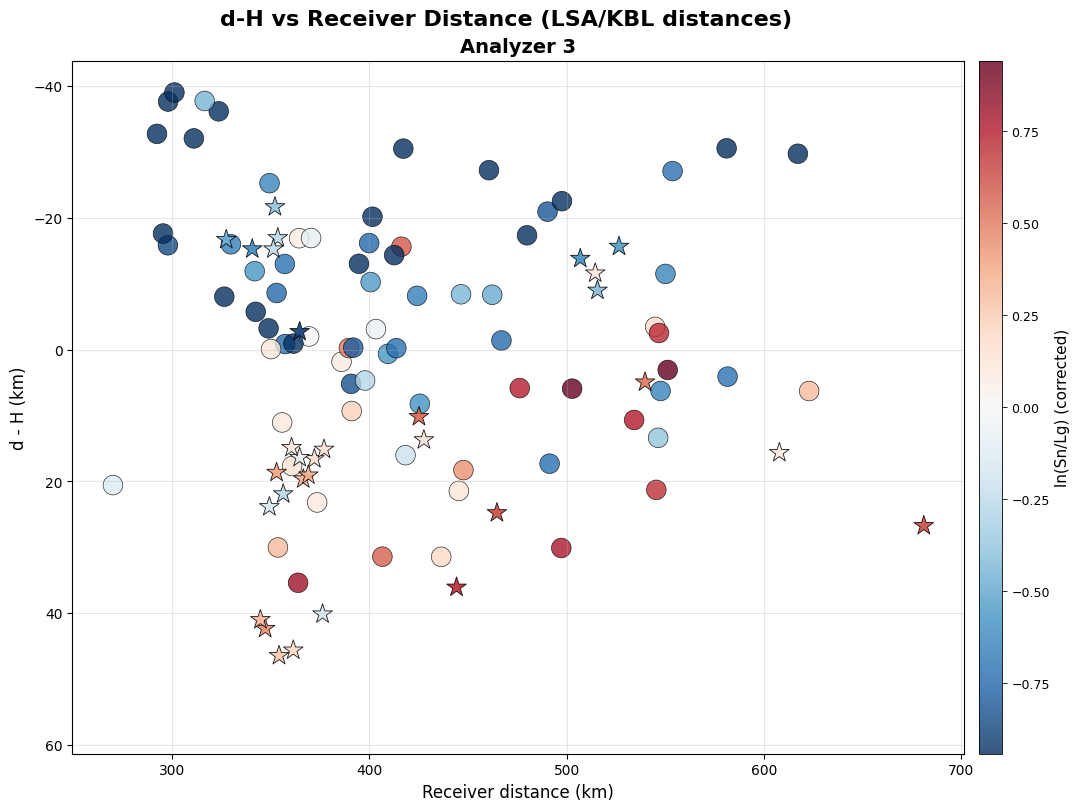

In [4]:
# Select analyzer to plot (1–4)
ANALYZER_INDEX = 3

STATION_COORDS = {
	'LSA': (29.6573, 91.1042),
	'KBL': (34.53, 69.17),
}

rows = []
with open(INPUT_TXT, 'r') as f:
	rdr = csv.reader(f, delimiter='\t')
	for r in rdr:
		if r: rows.append(r)

recv_dist_km_1, recv_dist_km_2, recv_dist_km_3, recv_dist_km_4 = [], [], [], []
d_h_all = []
is_star_all = []

y1, y2, y3, y4 = [], [], [], []
snr1, snr2, snr3, snr4 = [], [], [], []
snr1_sn, snr1_lg = [], []
snr2_sn, snr2_lg = [], []
snr3_sn, snr3_lg = [], []
snr4_sn, snr4_lg = [], []

for r in rows:
	evla = float(r[1]); evlo = float(r[2])
	d_h_all.append(float(r[6]) if r[6] != '' else np.nan)
	is_star_all.append(r[7] == '*')

	# Analyzer 1
	s1 = r[8]; st1 = 'LSA' if 'LSA' in s1 else 'KBL'
	dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st1][0], STATION_COORDS[st1][1])
	recv_dist_km_1.append(dist_m / 1000.0)
	y1.append(float(r[9]) if r[9] != '' else np.nan)
	snr1.append(float(r[11]) if r[11] != '' else np.nan)
	snr1_sn.append(float(r[12]) if r[12] != '' else np.nan)
	snr1_lg.append(float(r[13]) if r[13] != '' else np.nan)

	# Analyzer 2
	s2 = r[14]; st2 = 'LSA' if 'LSA' in s2 else 'KBL'
	dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st2][0], STATION_COORDS[st2][1])
	recv_dist_km_2.append(dist_m / 1000.0)
	y2.append(float(r[15]) if r[15] != '' else np.nan)
	snr2.append(float(r[17]) if r[17] != '' else np.nan)
	snr2_sn.append(float(r[18]) if r[18] != '' else np.nan)
	snr2_lg.append(float(r[19]) if r[19] != '' else np.nan)

	# Analyzer 3
	s3 = r[20]; st3 = 'LSA' if 'LSA' in s3 else 'KBL'
	dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st3][0], STATION_COORDS[st3][1])
	recv_dist_km_3.append(dist_m / 1000.0)
	y3.append(float(r[21]) if r[21] != '' else np.nan)
	snr3.append(float(r[23]) if r[23] != '' else np.nan)
	snr3_sn.append(float(r[24]) if r[24] != '' else np.nan)
	snr3_lg.append(float(r[25]) if r[25] != '' else np.nan)

	# Analyzer 4
	s4 = r[26]; st4 = 'LSA' if 'LSA' in s4 else 'KBL'
	dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st4][0], STATION_COORDS[st4][1])
	recv_dist_km_4.append(dist_m / 1000.0)
	y4.append(float(r[27]) if r[27] != '' else np.nan)
	snr4.append(float(r[29]) if r[29] != '' else np.nan)
	snr4_sn.append(float(r[30]) if r[30] != '' else np.nan)
	snr4_lg.append(float(r[31]) if r[31] != '' else np.nan)

recv_dist_km_1 = np.array(recv_dist_km_1)
recv_dist_km_2 = np.array(recv_dist_km_2)
recv_dist_km_3 = np.array(recv_dist_km_3)
recv_dist_km_4 = np.array(recv_dist_km_4)
d_h_all = np.array(d_h_all)
is_star_all = np.array(is_star_all, dtype=bool)

y1 = np.array(y1); y2 = np.array(y2); y3 = np.array(y3); y4 = np.array(y4)
snr1 = np.array(snr1); snr2 = np.array(snr2); snr3 = np.array(snr3); snr4 = np.array(snr4)
snr1_sn = np.array(snr1_sn); snr1_lg = np.array(snr1_lg)
snr2_sn = np.array(snr2_sn); snr2_lg = np.array(snr2_lg)
snr3_sn = np.array(snr3_sn); snr3_lg = np.array(snr3_lg)
snr4_sn = np.array(snr4_sn); snr4_lg = np.array(snr4_lg)

analyzers = {
	1: (recv_dist_km_1, y1, "Analyzer 1", snr1, snr1_sn, snr1_lg),
	2: (recv_dist_km_2, y2, "Analyzer 2", snr2, snr2_sn, snr2_lg),
	3: (recv_dist_km_3, y3, "Analyzer 3", snr3, snr3_sn, snr3_lg),
	4: (recv_dist_km_4, y4, "Analyzer 4", snr4, snr4_sn, snr4_lg),
}
xvals, yvals, title, snr_vals, snr_sn_vals, snr_lg_vals = analyzers[int(ANALYZER_INDEX)]

cmap_name = 'RdBu_r'
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

neutral_value = 0.0
saturation_factor = 0.5

base_mask_common = is_star_all if plotStarOnly else np.ones_like(is_star_all, dtype=bool)
if plotSNROnly:
	snr_mask = snr_vals > snlg_SNR_threshold
elif plotSNROnly2:
	snr_mask = (snr_sn_vals > snlg_SNR_threshold_2) & (snr_lg_vals > snlg_SNR_threshold_2)
else:
	snr_mask = np.ones_like(yvals, dtype=bool)

valid_y = np.isfinite(yvals)
global_mask = base_mask_common & valid_y & snr_mask

if np.any(global_mask):
	valid_vals = yvals[global_mask]
	max_dev = float(max(abs(np.nanmax(valid_vals) - neutral_value),
						abs(np.nanmin(valid_vals) - neutral_value)))
	if not np.isfinite(max_dev) or max_dev == 0:
		max_dev = 1e-6
else:
	max_dev = 1e-6

vmin_plot = neutral_value - (max_dev * saturation_factor)
vmax_plot = neutral_value + (max_dev * saturation_factor)

if d_h_all.size:
	ymin, ymax = float(np.nanmin(d_h_all)), float(np.nanmax(d_h_all))
	pad = 0.05 * max(ymax - ymin, 1e-6)
	y_lower, y_upper = ymax + pad, ymin - pad

if plotStarOnly:
	regular_base = np.zeros_like(is_star_all, dtype=bool)
	special_base = is_star_all
else:
	regular_base = ~is_star_all
	special_base = is_star_all

scatter_for_cbar = None

regular_mask = regular_base & valid_y & snr_mask
if np.any(regular_mask):
	sc_reg = ax.scatter(
		xvals[regular_mask], d_h_all[regular_mask],
		c=yvals[regular_mask], cmap=cmap_name, vmin=vmin_plot, vmax=vmax_plot,
		marker='o', s=200, alpha=0.8, edgecolors='black', linewidth=0.5
	)
	if scatter_for_cbar is None: scatter_for_cbar = sc_reg
	if plotLabels:
		for idx in np.where(regular_mask)[0]:
			ax.annotate(f'{d_h_all[idx]:.2f}', (xvals[idx], d_h_all[idx]),
						xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

special_mask = special_base & valid_y & snr_mask
if np.any(special_mask):
	sc_spec = ax.scatter(
		xvals[special_mask], d_h_all[special_mask],
		c=yvals[special_mask], cmap=cmap_name, vmin=vmin_plot, vmax=vmax_plot,
		marker='*', s=220, alpha=0.9, edgecolors='black', linewidth=0.6
	)
	if scatter_for_cbar is None: scatter_for_cbar = sc_spec
	if plotLabels:
		for idx in np.where(special_mask)[0]:
			ax.annotate(f'{d_h_all[idx]:.2f}', (xvals[idx], d_h_all[idx]),
						xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.9, weight='bold')

ax.set_xlabel('Receiver distance (km)', fontsize=12)
ax.set_ylabel('d - H (km)', fontsize=12)
ax.set_title(title, fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

if d_h_all.size:
	ax.set_ylim(y_lower, y_upper)
	ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
	ax.tick_params(axis='y', which='both', labelleft=True)

# Append a slim colorbar axis to the right of the plot (no overlap)
if scatter_for_cbar is not None:
	divider = make_axes_locatable(ax)
	cax = divider.append_axes("right", size="2.5%", pad=0.15)  # smaller width and clear padding
	cbar = fig.colorbar(scatter_for_cbar, cax=cax)
	cbar.set_label('ln(Sn/Lg) (corrected)', fontsize=11)
	cbar.ax.tick_params(labelsize=9, width=0.6)
	cbar.outline.set_linewidth(0.6)

plt.suptitle('d-H vs Receiver Distance (LSA/KBL distances)', fontsize=16, fontweight='bold')
plt.show()

# COMBINING ANALYZERS 

## Plot and score

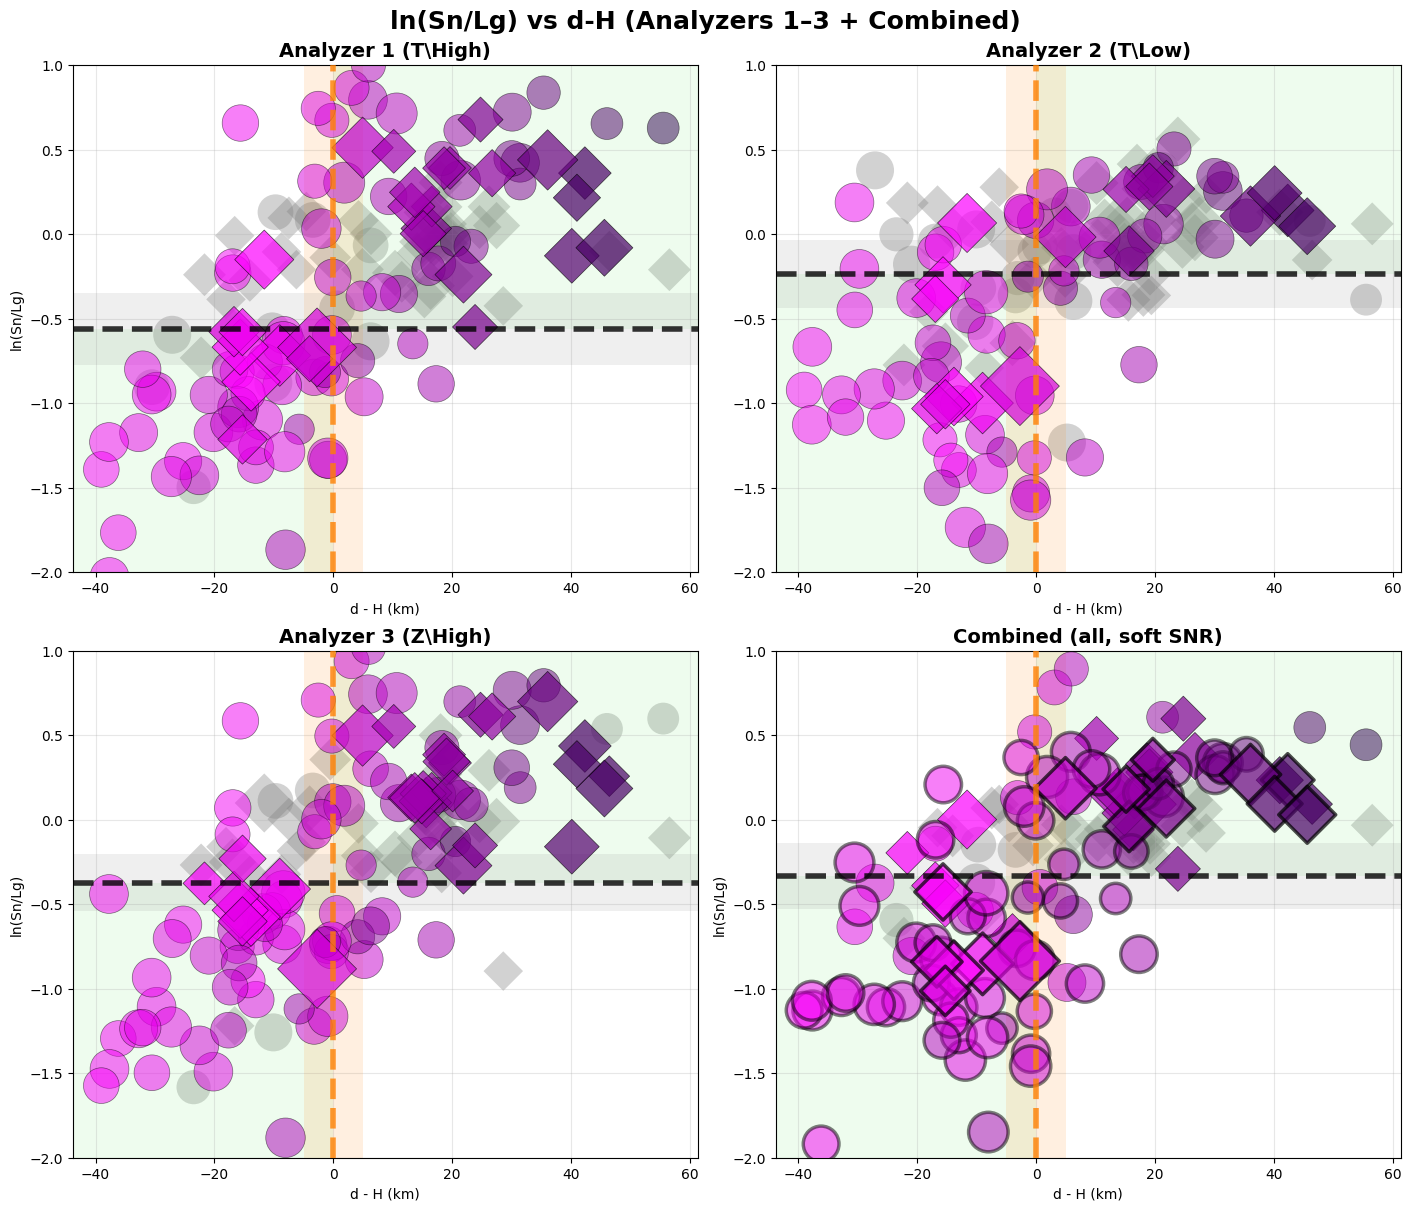

===== Plot Statistics =====
Analyzer 1: total points = 97, special points = 27
----Scores AFTER SNR Filtering----
  All events that pass SNR = 0.9253 (points=97); All special events that pass SNR = 0.9535 (points=27)
  All events that pass SNR, error band not included = 0.8504 (points=97); All special events that pass SNR, error band not included = 0.9535 (points=27)
----Scores BEFORE SNR Filtering----
  All events, even if fail SNR = 0.8932 (points=145); All special events, even if fail SNR = 0.8709 (points=65)
  All events, even if fail SNR, error band not included = 0.8065 (points=145); All special events, even if fail SNR, error band not included = 0.8212 (points=65)
Analyzer 2: total points = 79, special points = 18
----Scores AFTER SNR Filtering----
  All events that pass SNR = 0.9386 (points=79); All special events that pass SNR = 0.9303 (points=18)
  All events that pass SNR, error band not included = 0.8321 (points=79); All special events that pass SNR, error band not included

In [10]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, Normalize

# ---------------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------------
INPUT_TXT = '/Users/emmanuelzheng/Downloads/Synthetics/Seiobs/Combined_Results.txt'
plotSNROnly = True               # gate by combined SNR (snr_total > snlg_SNR_threshold)
plotSNROnly2 = False             # gate by Sn and Lg pair (both > snlg_SNR_threshold_2)
plotStarOnly = False             # show only “special” events if True
plotLabels = False               # draw text for special points
snlg_SNR_threshold = 3.0
snlg_SNR_threshold_2 = 2.0
MOHO_ERROR_BAND = 5.0
THRESH_ERROR_BAND_FALLBACK = 0.175
Y_LO_Q = 0.10
Y_HI_Q = 0.95
Y_EXTRA_FRAC = 0.15
REWARD_VALUE = 1.0
LOSS_SCALE = 1.0

# Weight/combination controls
WEIGHT_MIN = 1.0
WEIGHT_MAX = 5.0
WEIGHT_SOURCE_MODE = "all"    # 'special', 'special_restrict', 'all', 'all_restrict'
INCLUDE_FAILED_SNR = True
FAILED_SNR_FACTOR = 0.1       # only used when INCLUDE_FAILED_SNR is True

ANALYZER_SPECS = {
    1: dict(value_idx=9,  snr_idx=11, snr_sn_idx=12, snr_lg_idx=13, err_idx=10, label="Analyzer 1 (T\\High)"),
    2: dict(value_idx=15, snr_idx=17, snr_sn_idx=18, snr_lg_idx=19, err_idx=16, label="Analyzer 2 (T\\Low)"),
    3: dict(value_idx=21, snr_idx=23, snr_sn_idx=24, snr_lg_idx=25, err_idx=22, label="Analyzer 3 (Z\\High)"),
}
DEFAULT_LN_LINES = {1: -0.40, 2: -0.25, 3: -0.25}

# ---------------------------------------------------------------------------
# Data loading
# ---------------------------------------------------------------------------
def safe_float(token: str) -> float:
    try:
        return float(token)
    except (TypeError, ValueError):
        return np.nan

with open(INPUT_TXT, 'r') as f:
    rows = [row for row in csv.reader(f, delimiter='\t') if row]

d_h_values = np.array([safe_float(r[6]) for r in rows])
is_special = np.array([r[7] == '*' for r in rows], dtype=bool)
event_mags = np.array([safe_float(r[5]) for r in rows])
event_depths = np.array([safe_float(r[3]) for r in rows])

analyzers = {}
for idx, spec in ANALYZER_SPECS.items():
    analyzers[idx] = {
        'ln_vals':   np.array([safe_float(r[spec['value_idx']]) for r in rows]),
        'snr_total': np.array([safe_float(r[spec['snr_idx']])    for r in rows]),
        'snr_sn':    np.array([safe_float(r[spec['snr_sn_idx']]) for r in rows]),
        'snr_lg':    np.array([safe_float(r[spec['snr_lg_idx']]) for r in rows]),
        'err':       np.array([safe_float(r[spec['err_idx']])    for r in rows]),
        'label':     spec['label'],
    }

# ---------------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------------
def compute_snr_mask(snr_total, snr_sn, snr_lg):
    mask = np.ones_like(snr_total, dtype=bool)
    if plotSNROnly:
        mask &= snr_total > snlg_SNR_threshold
    if plotSNROnly2:
        mask &= (snr_sn > snlg_SNR_threshold_2) & (snr_lg > snlg_SNR_threshold_2)
    return mask

def add_guides_and_shading(ax, d_h_line, ln_line, x_limits, y_limits, thresh_band):
    x_min, x_max = x_limits
    y_floor, y_ceil = y_limits

    # Dashed axes
    ax.axvline(x=d_h_line, color='#ff8001', linestyle='--', alpha=0.8, linewidth=4, zorder=5)
    ax.axhline(y=ln_line,  color='black',  linestyle='--', alpha=0.8, linewidth=4, zorder=5)

    # Error bands
    guides = [
        Rectangle((d_h_line - MOHO_ERROR_BAND, y_floor),
                  width=MOHO_ERROR_BAND * 2.0,
                  height=y_ceil - y_floor,
                  facecolor='#ff8001', edgecolor='none', alpha=0.12, zorder=1.6),
        Rectangle((x_min, ln_line - thresh_band),
                  width=x_max - x_min,
                  height=thresh_band * 2.0,
                  facecolor='gray', edgecolor='none', alpha=0.12, zorder=1.6),
    ]
    for rect in guides:
        ax.add_patch(rect)

    # Preferred quadrants (LL and UR)
    if d_h_line > x_min and ln_line > y_floor:
        ax.add_patch(Rectangle((x_min, y_floor),
                               width=d_h_line - x_min,
                               height=ln_line - y_floor,
                               facecolor='lightgreen', edgecolor='none', alpha=0.15, zorder=1))
    if d_h_line < x_max and ln_line < y_ceil:
        ax.add_patch(Rectangle((d_h_line, ln_line),
                               width=x_max - d_h_line,
                               height=y_ceil - ln_line,
                               facecolor='lightgreen', edgecolor='none', alpha=0.15, zorder=1))

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_floor, y_ceil)

def choose_horizontal_line(x_vals, y_vals, default_line):
    if x_vals.size == 0:
        return default_line
    finite_mask = np.isfinite(y_vals)
    unique_y = np.unique(y_vals[finite_mask])
    if unique_y.size == 0:
        return default_line
    candidates = set(unique_y.tolist())
    if unique_y.size > 1:
        midpoints = (unique_y[1:] + unique_y[:-1]) / 2.0
        candidates.update(midpoints.tolist())
    best_line = default_line
    best_good = -1
    best_bad = np.inf
    d_h_line = 0.0
    for threshold in sorted(candidates):
        above = y_vals >= threshold
        right = x_vals >= d_h_line
        good = np.sum((above & right) | (~above & ~right))
        bad  = np.sum((above & ~right) | (~above & right))
        if good > best_good or (good == best_good and bad < best_bad):
            best_line = float(threshold)
            best_good = good
            best_bad = bad
    return best_line

def compute_scores(x_vals, y_vals, ln_line, thresh_band, include_band=True):
    # Normalized reward/loss with axis-normalized distances in [-1, 1]
    count = x_vals.size
    if count == 0:
        return 0.0, 0

    d_h_line = 0.0

    finite_x = np.isfinite(x_vals)
    finite_y = np.isfinite(y_vals)

    max_dx = np.max(np.abs(x_vals[finite_x] - d_h_line)) if np.any(finite_x) else 1.0
    max_dx = max(max_dx, 1e-6)
    max_dy = np.max(np.abs(y_vals[finite_y] - ln_line)) if np.any(finite_y) else 1.0
    max_dy = max(max_dy, 1e-6)

    in_good = ((x_vals >= d_h_line) & (y_vals >= ln_line)) | ((x_vals < d_h_line) & (y_vals < ln_line))
    if include_band:
        in_band = (np.abs(x_vals - d_h_line) <= MOHO_ERROR_BAND) | (np.abs(y_vals - ln_line) <= thresh_band)
        reward_mask = in_good | in_band
    else:
        reward_mask = in_good

    reward_total = REWARD_VALUE * np.count_nonzero(reward_mask)
    bad_mask = ~reward_mask

    if not np.any(bad_mask):
        return reward_total / count, count

    horiz_norm = np.abs(x_vals[bad_mask] - d_h_line) / max_dx
    vert_norm = np.abs(y_vals[bad_mask] - ln_line) / max_dy
    distances = np.minimum(horiz_norm, vert_norm)

    loss_total = LOSS_SCALE * np.sum(distances)
    return (reward_total - loss_total) / count, count

def rescale_weights(weight_dict, low, high):
    values = np.array(list(weight_dict.values()), dtype=float)
    finite_mask = np.isfinite(values)
    if not finite_mask.any():
        return {k: (low + high) / 2.0 for k in weight_dict}
    vals = values[finite_mask]
    vmin, vmax = vals.min(), vals.max()
    if np.isclose(vmax, vmin):
        return {k: (low + high) / 2.0 for k in weight_dict}
    scaled = {}
    for k, v in weight_dict.items():
        if not np.isfinite(v):
            v = vmin
        v = np.clip(v, vmin, vmax)
        scaled[k] = low + (v - vmin) * (high - low) / (vmax - vmin)
    return scaled

# ---------------------------------------------------------------------------
# Shared masks and styling
# ---------------------------------------------------------------------------
valid_x = np.isfinite(d_h_values)
base_mask = is_special if plotStarOnly else np.ones_like(is_special, dtype=bool)
regular_base = np.zeros_like(is_special, dtype=bool) if plotStarOnly else ~is_special
special_base = is_special

# Point sizes by magnitude
mag_isfinite = np.isfinite(event_mags)
sizes_all = np.where(mag_isfinite, np.power(np.maximum(event_mags, 0.0), 1.8) * 50.0, 30.0)

# Depth colormap
depth_isfinite = np.isfinite(event_depths)
if np.any(depth_isfinite):
    depth_min = float(np.nanmin(event_depths[depth_isfinite]))
    depth_max = float(np.nanmax(event_depths[depth_isfinite]))
else:
    depth_min, depth_max = 0.0, 1.0
depth_cmap = LinearSegmentedColormap.from_list('magenta_to_darkpurple', ['#ff00ff', '#2e004f'])
depth_norm = Normalize(vmin=depth_min, vmax=depth_max)

# Y-limits across all analyzers (using SNR-masked points)
y_all = []
for data in analyzers.values():
    mask = compute_snr_mask(data['snr_total'], data['snr_sn'], data['snr_lg'])
    valid_y = np.isfinite(data['ln_vals'])
    combined_mask = base_mask & valid_x & valid_y & mask
    if np.any(combined_mask):
        y_all.append(data['ln_vals'][combined_mask])

if y_all:
    y_all = np.concatenate(y_all)
    y_lo = float(np.nanpercentile(y_all, Y_LO_Q * 100.0))
    y_hi = float(np.nanpercentile(y_all, Y_HI_Q * 100.0))
    span = y_hi - y_lo
    if not np.isfinite(span) or span <= 0:
        y_lo, y_hi, span = -1.0, 1.0, 2.0
    y_min_zoom = y_lo - span * Y_EXTRA_FRAC
    y_max_zoom = y_hi + span * Y_EXTRA_FRAC
    y_min_zoom = min(y_min_zoom, 0.0)
    y_max_zoom = max(y_max_zoom, 0.0)
else:
    y_min_zoom, y_max_zoom = -1.0, 1.0

def _nice_step(ymin, ymax, target_ticks=6):
    rng = float(ymax - ymin) if np.isfinite(ymax - ymin) and ymax > ymin else 1.0
    raw = rng / max(target_ticks, 1)
    if raw == 0 or not np.isfinite(raw):
        return 0.1
    exp = int(np.floor(np.log10(raw)))
    scale = 10.0 ** exp
    norm = raw / scale
    for base in [1.0, 2.0, 2.5, 5.0, 10.0]:
        if norm <= base:
            return base * scale
    return 10.0 * scale

y_tick_step = _nice_step(y_min_zoom, y_max_zoom, target_ticks=6)
if np.isfinite(y_tick_step) and y_tick_step > 0:
    y_floor = np.floor(y_min_zoom / y_tick_step) * y_tick_step
    y_ceil = np.ceil(y_max_zoom / y_tick_step) * y_tick_step
else:
    y_floor, y_ceil = y_min_zoom, y_max_zoom
if not np.isfinite(y_floor) or not np.isfinite(y_ceil) or y_floor == y_ceil:
    y_floor, y_ceil = -1.0, 1.0

# ---------------------------------------------------------------------------
# Plot analyzers + combined in 2×2 grid (all square)
# ---------------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)
axes_dict = {(0, 0): axes[0, 0], (0, 1): axes[0, 1], (1, 0): axes[1, 0], (1, 1): axes[1, 1]}

thresh_band_summary = {}
ln_line_summary = {}
score_summary = {}
score_special_summary = {}
score_restrict_summary = {}
score_restrict_special_summary = {}
score_all_failed_summary = {}
score_special_failed_summary = {}
score_restrict_all_failed_summary = {}
score_restrict_special_failed_summary = {}

slot_map = {1: (0, 0), 2: (0, 1), 3: (1, 0)}
for idx, grid_pos in slot_map.items():
    ax = axes_dict[grid_pos]
    data = analyzers[idx]
    d_h_line = 0.0

    # Masks
    snr_mask = compute_snr_mask(data['snr_total'], data['snr_sn'], data['snr_lg'])
    valid_y = np.isfinite(data['ln_vals'])
    mask_valid = base_mask & valid_x & valid_y
    mask_common = mask_valid & snr_mask

    # Plot failed SNR in gray (preserve size and marker by special)
    fail_mask = mask_valid & ~snr_mask
    fail_regular = fail_mask & (~special_base)
    fail_special = fail_mask & special_base
    if np.any(fail_regular):
        ax.scatter(
            d_h_values[fail_regular],
            data['ln_vals'][fail_regular],
            color='gray',
            alpha=0.35,
            s=sizes_all[fail_regular],
            marker='o',
            edgecolors='none',
            zorder=1,
        )
    if np.any(fail_special):
        ax.scatter(
            d_h_values[fail_special],
            data['ln_vals'][fail_special],
            color='gray',
            alpha=0.35,
            s=sizes_all[fail_special],
            marker='D',
            edgecolors='none',
            zorder=1,
        )

    # Plot passing SNR with colors
    regular_mask = regular_base & mask_common
    special_mask = special_base & mask_common

    if np.any(regular_mask):
        ax.scatter(
            d_h_values[regular_mask],
            data['ln_vals'][regular_mask],
            c=event_depths[regular_mask],
            cmap=depth_cmap,
            norm=depth_norm,
            s=sizes_all[regular_mask],
            marker='o',
            alpha=0.5,
            edgecolors='k',
            linewidths=0.5,
            zorder=2,
        )
    if np.any(special_mask):
        ax.scatter(
            d_h_values[special_mask],
            data['ln_vals'][special_mask],
            c=event_depths[special_mask],
            cmap=depth_cmap,
            norm=depth_norm,
            s=sizes_all[special_mask],
            marker='D',
            alpha=0.7,
            edgecolors='k',
            linewidths=0.5,
            zorder=3,
        )
        if plotLabels:
            for i_pt in np.where(special_mask)[0]:
                ax.annotate(
                    f'{d_h_values[i_pt]:.2f}',
                    (d_h_values[i_pt], data['ln_vals'][i_pt]),
                    xytext=(5, 5),
                    textcoords='offset points',
                    fontsize=8,
                    alpha=0.9,
                    weight='bold',
                )

    # Dynamic horizontal line from plotted points
    x_plotted = d_h_values[mask_common]
    y_plotted = data['ln_vals'][mask_common]
    ln_line = choose_horizontal_line(x_plotted, y_plotted, DEFAULT_LN_LINES[idx])
    ln_line_summary[idx] = ln_line

    # Error band for this analyzer: average of errors for plotted points (finite err)
    finite_err_mask = mask_common & np.isfinite(data['err'])
    if np.any(finite_err_mask):
        thresh_band = float(np.nanmean(data['err'][finite_err_mask]))
    else:
        thresh_band = THRESH_ERROR_BAND_FALLBACK
    thresh_band_summary[idx] = thresh_band

    # Axes and shading
    ax.set_ylim(y_floor, y_ceil)
    x_limits = ax.get_xlim()
    add_guides_and_shading(ax, d_h_line, ln_line, x_limits, (y_floor, y_ceil), thresh_band)

    ax.set_title(data['label'], fontsize=14, fontweight='bold')
    ax.set_xlabel('d - H (km)')
    ax.grid(True, alpha=0.3)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(y_tick_step))
    if grid_pos[1] == 0:
        ax.set_ylabel('ln(Sn/Lg)')

    total_points = np.sum(mask_common & (~special_base)) + np.sum(mask_common & special_base)
    total_special = np.sum(mask_common & special_base)

    # Scores (normalized by count)
    score_val, score_count = compute_scores(x_plotted, y_plotted, ln_line, thresh_band, include_band=True)
    score_summary[idx] = (score_val, score_count, total_points, total_special)

    score_restrict_val, score_restrict_count = compute_scores(
        x_plotted, y_plotted, ln_line, thresh_band, include_band=False
    )
    score_restrict_summary[idx] = (score_restrict_val, score_restrict_count)

    special_points_mask = mask_common & special_base
    x_special = d_h_values[special_points_mask]
    y_special = data['ln_vals'][special_points_mask]
    score_special_val, score_special_count = compute_scores(
        x_special, y_special, ln_line, thresh_band, include_band=True
    )
    if score_special_count == 0:
        score_special_summary[idx] = None
    else:
        score_special_summary[idx] = (score_special_val, score_special_count)

    score_restrict_special_val, score_restrict_special_count = compute_scores(
        x_special, y_special, ln_line, thresh_band, include_band=False
    )
    if score_restrict_special_count == 0:
        score_restrict_special_summary[idx] = None
    else:
        score_restrict_special_summary[idx] = (score_restrict_special_val, score_restrict_special_count)

    # Scores over all finite points (including failed SNR)
    x_all = d_h_values[mask_valid]
    y_all_local = data['ln_vals'][mask_valid]
    score_all_failed, count_all_failed = compute_scores(x_all, y_all_local, ln_line, thresh_band, include_band=True)
    score_restrict_all_failed, count_restrict_all_failed = compute_scores(
        x_all, y_all_local, ln_line, thresh_band, include_band=False
    )
    score_all_failed_summary[idx] = (score_all_failed, count_all_failed)
    score_restrict_all_failed_summary[idx] = (score_restrict_all_failed, count_restrict_all_failed)

    special_all_mask = mask_valid & special_base
    x_special_all = d_h_values[special_all_mask]
    y_special_all = data['ln_vals'][special_all_mask]
    score_special_failed, count_special_failed = compute_scores(
        x_special_all, y_special_all, ln_line, thresh_band, include_band=True
    )
    score_restrict_special_failed, count_restrict_special_failed = compute_scores(
        x_special_all, y_special_all, ln_line, thresh_band, include_band=False
    )

    if count_special_failed == 0:
        score_special_failed_summary[idx] = None
    else:
        score_special_failed_summary[idx] = (score_special_failed, count_special_failed)

    if count_restrict_special_failed == 0:
        score_restrict_special_failed_summary[idx] = None
    else:
        score_restrict_special_failed_summary[idx] = (score_restrict_special_failed, count_restrict_special_failed)

# ---------------------------------------------------------------------------
# Combined plot (bottom-right square) with CORRECT error variance combination
# ---------------------------------------------------------------------------
ax_combined = axes_dict[(1, 1)]
num_events = len(d_h_values)
analyzer_ids = sorted(analyzers.keys())

ln_stack = np.vstack([analyzers[idx]['ln_vals'] for idx in analyzer_ids])
err_stack = np.vstack([analyzers[idx]['err'] for idx in analyzer_ids])

# Per-analyzer pass and validity
snr_pass_stack = []
valid_data_stack = []
for idx in analyzer_ids:
    data = analyzers[idx]
    snr_pass_stack.append(compute_snr_mask(data['snr_total'], data['snr_sn'], data['snr_lg']))
    valid_mask = base_mask & valid_x & np.isfinite(data['ln_vals']) & np.isfinite(data['err'])
    valid_data_stack.append(valid_mask)
snr_pass_stack = np.vstack(snr_pass_stack)
valid_data_stack = np.vstack(valid_data_stack)

# Count how many analyzers pass SNR (and are valid) for each event
success_counts = np.sum(snr_pass_stack & valid_data_stack, axis=0)

def resolve_weight_source(idx):
    if WEIGHT_SOURCE_MODE == "special":
        entry = score_special_summary[idx]
        if entry is not None:
            return entry[0]
        return score_summary[idx][0]
    if WEIGHT_SOURCE_MODE == "special_restrict":
        entry = score_restrict_special_summary[idx]
        if entry is not None:
            return entry[0]
        fallback = score_special_summary[idx]
        if fallback is not None:
            return fallback[0]
        return score_summary[idx][0]
    if WEIGHT_SOURCE_MODE == "all":
        return score_summary[idx][0]
    if WEIGHT_SOURCE_MODE == "all_restrict":
        return score_restrict_summary[idx][0]
    raise ValueError("WEIGHT_SOURCE_MODE must be one of 'special', 'special_restrict', 'all', 'all_restrict'.")

# Build analyzer-level weights from chosen source metric, then rescale to [WEIGHT_MIN, WEIGHT_MAX]
raw_weight_dict = {}
for idx in analyzer_ids:
    metric = resolve_weight_source(idx)
    raw_weight_dict[idx] = max(metric, 0.0)
analyzer_weights_dict = rescale_weights(raw_weight_dict, WEIGHT_MIN, WEIGHT_MAX)

# Resolve combined per-event mean and CORRECT variance-based sigma
combined_ln = np.full(num_events, np.nan, dtype=float)
combined_sigma = np.full(num_events, np.nan, dtype=float)
combined_mask = np.zeros(num_events, dtype=bool)

for event_idx in range(num_events):
    num_ln = 0.0                  # numerator for weighted mean
    weight_sum = 0.0              # denominator for weighted mean
    variance_numerator = 0.0      # Σ (w_i^2 * σ_i^2)
    passing_total_weight = 0.0    # sum of weights from analyzers that PASS SNR

    for lane, idx in enumerate(analyzer_ids):
        if not valid_data_stack[lane, event_idx]:
            continue

        base_weight = analyzer_weights_dict[idx]
        if base_weight <= 0:
            continue

        if snr_pass_stack[lane, event_idx]:
            adj_weight = base_weight
            passing_total_weight += adj_weight
        elif INCLUDE_FAILED_SNR:
            adj_weight = base_weight * FAILED_SNR_FACTOR
            if adj_weight <= 0:
                continue
        else:
            continue

        ln_val = ln_stack[lane, event_idx]
        sigma_i = err_stack[lane, event_idx]  # 1σ for analyzer i

        num_ln += adj_weight * ln_val
        weight_sum += adj_weight
        variance_numerator += (adj_weight ** 2) * (sigma_i ** 2)

    # Stats-only include: require at least 1 analyzer that passed SNR
    if passing_total_weight == 0 or weight_sum <= 0:
        continue

    combined_ln[event_idx] = num_ln / weight_sum
    combined_sigma[event_idx] = np.sqrt(variance_numerator) / weight_sum
    combined_mask[event_idx] = True

combined_special_mask = combined_mask & is_special
combined_regular_mask = combined_mask & (~is_special)
if plotStarOnly:
    combined_regular_mask[:] = False

# Additional combined values for ALL-FAIL events (0 analyzers pass), for plotting only (do not affect stats)
valid_any_mask = np.any(valid_data_stack, axis=0)  # at least one analyzer has finite ln and err
allfail_plot_mask = (success_counts == 0) & valid_any_mask

combined_ln_allfail = np.full(num_events, np.nan, dtype=float)
if np.any(allfail_plot_mask):
    for event_idx in np.where(allfail_plot_mask)[0]:
        num_ln = 0.0
        weight_sum = 0.0
        for lane, idx in enumerate(analyzer_ids):
            if not valid_data_stack[lane, event_idx]:
                continue
            base_weight = analyzer_weights_dict[idx]
            if base_weight <= 0:
                continue
            # All fail: use reduced weight factor uniformly
            adj_weight = base_weight * FAILED_SNR_FACTOR
            num_ln += adj_weight * ln_stack[lane, event_idx]
            weight_sum += adj_weight
        if weight_sum > 0:
            combined_ln_allfail[event_idx] = num_ln / weight_sum

# Masks for plotting categories
have_all3_mask = combined_mask & (success_counts >= len(analyzer_ids))        # 3 pass
have_1or2_mask = combined_mask & (success_counts > 0) & (success_counts < len(analyzer_ids))  # 1-2 pass
have_none_mask = allfail_plot_mask                                           # 0 pass (plot-only)

all3_regular_mask = have_all3_mask & (~is_special)
all3_special_mask = have_all3_mask & is_special
partial_regular_mask = have_1or2_mask & (~is_special)
partial_special_mask = have_1or2_mask & is_special
none_regular_mask = have_none_mask & (~is_special)
none_special_mask = have_none_mask & is_special

# Plot combined: 3 measurements with THICK black outline + normal color
if np.any(all3_regular_mask):
    ax_combined.scatter(
        d_h_values[all3_regular_mask],
        combined_ln[all3_regular_mask],
        c=event_depths[all3_regular_mask],
        cmap=depth_cmap,
        norm=depth_norm,
        s=sizes_all[all3_regular_mask],
        marker='o',
        alpha=0.5,
        edgecolors='k',
        linewidths=2.5,
        zorder=4,
    )
if np.any(all3_special_mask):
    ax_combined.scatter(
        d_h_values[all3_special_mask],
        combined_ln[all3_special_mask],
        c=event_depths[all3_special_mask],
        cmap=depth_cmap,
        norm=depth_norm,
        s=sizes_all[all3_special_mask],
        marker='D',
        alpha=0.7,
        edgecolors='k',
        linewidths=2.5,
        zorder=5,
    )
    if plotLabels:
        for i_pt in np.where(all3_special_mask)[0]:
            ax_combined.annotate(
                f'{d_h_values[i_pt]:.2f}',
                (d_h_values[i_pt], combined_ln[i_pt]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.9,
                weight='bold',
            )

# Plot combined: 1-2 measurements in NORMAL color (thin outline)
if np.any(partial_regular_mask):
    ax_combined.scatter(
        d_h_values[partial_regular_mask],
        combined_ln[partial_regular_mask],
        c=event_depths[partial_regular_mask],
        cmap=depth_cmap,
        norm=depth_norm,
        s=sizes_all[partial_regular_mask],
        marker='o',
        alpha=0.5,
        edgecolors='k',
        linewidths=0.5,
        zorder=3,
    )
if np.any(partial_special_mask):
    ax_combined.scatter(
        d_h_values[partial_special_mask],
        combined_ln[partial_special_mask],
        c=event_depths[partial_special_mask],
        cmap=depth_cmap,
        norm=depth_norm,
        s=sizes_all[partial_special_mask],
        marker='D',
        alpha=0.7,
        edgecolors='k',
        linewidths=0.5,
        zorder=3,
    )

# Plot combined: 0 measurements (all fail SNR) in GRAY using combined_ln_allfail (plot-only)
if np.any(none_regular_mask):
    ax_combined.scatter(
        d_h_values[none_regular_mask],
        combined_ln_allfail[none_regular_mask],
        color='gray',
        alpha=0.35,
        s=sizes_all[none_regular_mask],
        marker='o',
        edgecolors='none',
        zorder=1,
    )
if np.any(none_special_mask):
    ax_combined.scatter(
        d_h_values[none_special_mask],
        combined_ln_allfail[none_special_mask],
        color='gray',
        alpha=0.35,
        s=sizes_all[none_special_mask],
        marker='D',
        edgecolors='none',
        zorder=1,
    )

# Dynamic horizontal line for combined (based on events with >=1 pass only)
combined_ln_line = choose_horizontal_line(d_h_values[combined_mask], combined_ln[combined_mask], -0.25)

# Horizontal error band for combined: mean of per-event σ_combined (variance-based), from stats set only
if np.any(combined_mask):
    combined_thresh_band = float(np.nanmean(combined_sigma[combined_mask]))
else:
    combined_thresh_band = THRESH_ERROR_BAND_FALLBACK

# Axes and shading for combined
ax_combined.set_ylim(y_floor, y_ceil)
combined_x_limits = ax_combined.get_xlim()
add_guides_and_shading(ax_combined, 0.0, combined_ln_line, combined_x_limits, (y_floor, y_ceil), combined_thresh_band)

ax_combined.set_title(f'Combined ({WEIGHT_SOURCE_MODE}, {"soft" if INCLUDE_FAILED_SNR else "hard"} SNR)', fontsize=14, fontweight='bold')
ax_combined.set_xlabel('d - H (km)')
ax_combined.set_ylabel('ln(Sn/Lg)')
ax_combined.grid(True, alpha=0.3)
ax_combined.yaxis.set_major_locator(mticker.MultipleLocator(y_tick_step))

# Scores for combined (unchanged; only events with >=1 pass)
combined_score_all, combined_count_all = compute_scores(
    d_h_values[combined_mask],
    combined_ln[combined_mask],
    combined_ln_line,
    combined_thresh_band,
    include_band=True,
)
combined_score_special, combined_count_special = compute_scores(
    d_h_values[combined_special_mask],
    combined_ln[combined_special_mask],
    combined_ln_line,
    combined_thresh_band,
    include_band=True,
)
combined_score_restrict_all, combined_count_restrict_all = compute_scores(
    d_h_values[combined_mask],
    combined_ln[combined_mask],
    combined_ln_line,
    combined_thresh_band,
    include_band=False,
)
combined_score_restrict_special, combined_count_restrict_special = compute_scores(
    d_h_values[combined_special_mask],
    combined_ln[combined_special_mask],
    combined_ln_line,
    combined_thresh_band,
    include_band=False,
)

# Scores for "all-3 pass" subset
all3_mask = combined_mask & (success_counts >= len(analyzer_ids))
all3_special_mask = all3_mask & is_special
combined_score_all_all3, combined_count_all_all3 = compute_scores(
    d_h_values[all3_mask],
    combined_ln[all3_mask],
    combined_ln_line,
    combined_thresh_band,
    include_band=True,
)
combined_score_restrict_all_all3, combined_count_restrict_all_all3 = compute_scores(
    d_h_values[all3_mask],
    combined_ln[all3_mask],
    combined_ln_line,
    combined_thresh_band,
    include_band=False,
)
combined_score_special_all3, combined_count_special_all3 = compute_scores(
    d_h_values[all3_special_mask],
    combined_ln[all3_special_mask],
    combined_ln_line,
    combined_thresh_band,
    include_band=True,
)
combined_score_restrict_special_all3, combined_count_restrict_special_all3 = compute_scores(
    d_h_values[all3_special_mask],
    combined_ln[all3_special_mask],
    combined_ln_line,
    combined_thresh_band,
    include_band=False,
)

fig.suptitle('ln(Sn/Lg) vs d-H (Analyzers 1–3 + Combined)', fontsize=18, fontweight='bold')
plt.show()

# ---------------------------------------------------------------------------
# Consolidated statistics (unchanged)
# ---------------------------------------------------------------------------
print("===== Plot Statistics =====")
for idx in sorted(score_summary):
    score_val, score_count, total_points, total_special = score_summary[idx]
    special_entry = score_special_summary[idx]
    restrict_entry = score_restrict_summary[idx]
    restrict_special_entry = score_restrict_special_summary[idx]
    all_failed_entry = score_all_failed_summary[idx]
    restrict_all_failed_entry = score_restrict_all_failed_summary[idx]
    special_failed_entry = score_special_failed_summary[idx]
    restrict_special_failed_entry = score_restrict_special_failed_summary[idx]

    score_special_text = (
        f"{special_entry[0]:.4f} (points={special_entry[1]})"
        if special_entry else "N/A (points=0)"
    )
    score_restrict_special_text = (
        f"{restrict_special_entry[0]:.4f} (points={restrict_special_entry[1]})"
        if restrict_special_entry else "N/A (points=0)"
    )
    score_special_failed_text = (
        f"{special_failed_entry[0]:.4f} (points={special_failed_entry[1]})"
        if special_failed_entry else "N/A (points=0)"
    )
    score_restrict_special_failed_text = (
        f"{restrict_special_failed_entry[0]:.4f} (points={restrict_special_failed_entry[1]})"
        if restrict_special_failed_entry else "N/A (points=0)"
    )

    print(f"\033[1mAnalyzer {idx}: total points = {total_points}, special points = {total_special}\033[0m")
    print("----Scores AFTER SNR Filtering----")
    print(f"  All events that pass SNR = {score_val:.4f} (points={score_count}); "
          f"All special events that pass SNR = {score_special_text}")
    print(f"  All events that pass SNR, error band not included = {restrict_entry[0]:.4f} "
          f"(points={restrict_entry[1]}); "
          f"All special events that pass SNR, error band not included = {score_restrict_special_text}")
    print("----Scores BEFORE SNR Filtering----")
    print(f"  All events, even if fail SNR = {all_failed_entry[0]:.4f} (points={all_failed_entry[1]}); "
          f"All special events, even if fail SNR = {score_special_failed_text}")
    print(f"  All events, even if fail SNR, error band not included = {restrict_all_failed_entry[0]:.4f} "
          f"(points={restrict_all_failed_entry[1]}); "
          f"All special events, even if fail SNR, error band not included = {score_restrict_special_failed_text}")

def fmt(label, value, count):
    return f"{label} = {value:.4f} (points={count})" if count else f"{label} = N/A (points=0)"

combined_total = int(np.sum(combined_mask))
combined_total_special = int(np.sum(combined_special_mask))
combined_total_all3 = int(np.sum(all3_mask))
combined_total_special_all3 = int(np.sum(all3_special_mask))

print(f"\033[1mCombined: total points = {combined_total}, special points = {combined_total_special}\033[0m")
print("----Scores AFTER SNR Filtering----")
print("  " + fmt("All events that have all 3 pass SNR", combined_score_all_all3, combined_count_all_all3) + "; " +
      fmt("All special events that have all 3 pass SNR", combined_score_special_all3, combined_count_special_all3))
print("  " + fmt("All events that have all 3 pass SNR, error band not included", combined_score_restrict_all_all3, combined_count_restrict_all_all3) + "; " +
      fmt("All special events that have all 3 pass SNR, error band not included", combined_score_restrict_special_all3, combined_count_restrict_special_all3))
print("----Scores BEFORE SNR Filtering----")
print("  " + fmt("All events, even if 1-2 analyzers fail SNR", combined_score_all, combined_count_all) + "; " +
      fmt("All special events, even if 1-2 analyzers fail SNR", combined_score_special, combined_count_special))
print("  " + fmt("All events, even if 1-2 analyzers fail SNR, error band not included", combined_score_restrict_all, combined_count_restrict_all) + "; " +
      fmt("All special events, even if 1-2 analyzers fail SNR, error band not included", combined_score_restrict_special, combined_count_restrict_special))

In [8]:
import pandas as pd

def fmt_val(val, cnt):
    return f"{val:.4f} ({cnt})" if cnt else "N/A (0)"

summary_rows = []

for idx in sorted(score_summary):
    label = analyzers[idx]['label']
    score_all, cnt_all, _, _ = score_summary[idx]
    score_restrict_all, cnt_restrict_all = score_restrict_summary[idx]

    special_entry = score_special_summary[idx]
    score_special_val = special_entry[0] if special_entry else None
    score_special_cnt = special_entry[1] if special_entry else 0

    restrict_special_entry = score_restrict_special_summary[idx]
    score_restrict_special_val = restrict_special_entry[0] if restrict_special_entry else None
    score_restrict_special_cnt = restrict_special_entry[1] if restrict_special_entry else 0

    all_failed_entry = score_all_failed_summary[idx]
    score_all_failed_val, score_all_failed_cnt = all_failed_entry

    special_failed_entry = score_special_failed_summary[idx]
    score_special_failed_val = special_failed_entry[0] if special_failed_entry else None
    score_special_failed_cnt = special_failed_entry[1] if special_failed_entry else 0

    restrict_all_failed_entry = score_restrict_all_failed_summary[idx]
    score_restrict_all_failed_val, score_restrict_all_failed_cnt = restrict_all_failed_entry

    restrict_special_failed_entry = score_restrict_special_failed_summary[idx]
    score_restrict_special_failed_val = (restrict_special_failed_entry[0]
                                         if restrict_special_failed_entry else None)
    score_restrict_special_failed_cnt = (restrict_special_failed_entry[1]
                                         if restrict_special_failed_entry else 0)

    summary_rows.append({
        "Plot": label,
        "All events that pass SNR": fmt_val(score_all, cnt_all),
        "Special events that pass SNR": fmt_val(score_special_val, score_special_cnt),
        "All events, including failed SNR": fmt_val(score_all_failed_val, score_all_failed_cnt),
        "Special events, including failed SNR": fmt_val(score_special_failed_val, score_special_failed_cnt),
        "All events that pass SNR (restrictive score)": fmt_val(score_restrict_all, cnt_restrict_all),
        "Special events that pass SNR (restrictive score)": fmt_val(score_restrict_special_val, score_restrict_special_cnt),
        "All events, including failed SNR (restrictive score)": fmt_val(score_restrict_all_failed_val, score_restrict_all_failed_cnt),
        "Special events, including failed SNR (restrictive score)": fmt_val(score_restrict_special_failed_val, score_restrict_special_failed_cnt),
    })

# Combined plot – four perspectives (updated variables)
summary_rows.append({
    "Plot": "Combined",
    "All events that pass SNR": fmt_val(combined_score_all_all3, combined_count_all_all3),
    "Special events that pass SNR": fmt_val(combined_score_special_all3, combined_count_special_all3),
    "All events, including failed SNR": fmt_val(combined_score_all, combined_count_all),  # no separate *_full in current code
    "Special events, including failed SNR": fmt_val(combined_score_special, combined_count_special),
    "All events that pass SNR (restrictive score)": fmt_val(combined_score_restrict_all_all3, combined_count_restrict_all_all3),
    "Special events that pass SNR (restrictive score)": fmt_val(combined_score_restrict_special_all3, combined_count_restrict_special_all3),
    "All events, including failed SNR (restrictive score)": fmt_val(combined_score_restrict_all, combined_count_restrict_all),
    "Special events, including failed SNR (restrictive score)": fmt_val(combined_score_restrict_special, combined_count_restrict_special)
})

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

,Plot,All events that pass SNR,Special events that pass SNR,"All events, including failed SNR","Special events, including failed SNR",All events that pass SNR (restrictive score),Special events that pass SNR (restrictive score),"All events, including failed SNR (restrictive score)","Special events, including failed SNR (restrictive score)"
0,Analyzer 1 (T\High),0.9253 (97),0.9535 (27),0.8932 (145),0.8709 (65),0.8504 (97),0.9535 (27),0.8065 (145),0.8212 (65)
1,Analyzer 2 (T\Low),0.9386 (79),0.9303 (18),0.8943 (145),0.8866 (65),0.8321 (79),0.9303 (18),0.7563 (145),0.7848 (65)
2,Analyzer 3 (Z\High),0.9198 (105),1.0000 (31),0.8936 (145),0.9056 (65),0.8401 (105),0.9635 (31),0.7781 (145),0.7736 (65)
3,Combined,0.9340 (75),1.0000 (15),0.9248 (110),0.9632 (34),0.8497 (75),1.0000 (15),0.8196 (110),0.9295 (34)
